Loading data...

Customer profile shape: (4194, 11)

Customer profile columns:
['CustomerID', 'AvgOrderValue', 'PurchaseVariability', 'DaysSinceFirstPurchase', 'AvgDaysBetweenPurchases', 'UniqueProducts', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']

Preparing dataset for churn prediction...
Most recent transaction date: 2011-12-09 12:50:00
Churn rate: 33.19%

Feature engineering for churn prediction...
Calculating purchase trends...
Processed 0 customers...
Processed 100 customers...
Processed 200 customers...
Processed 300 customers...
Processed 400 customers...
Processed 500 customers...
Processed 600 customers...
Processed 700 customers...
Processed 800 customers...
Processed 900 customers...
Processed 1000 customers...
Processed 1100 customers...
Processed 1200 customers...
Processed 1300 customers...
Processed 1400 customers...
Processed 1500 customers...
Processed 1600 customers...
Processed 1700 customers...
Processed 1800 customers...
Processed 1900 customers...
P

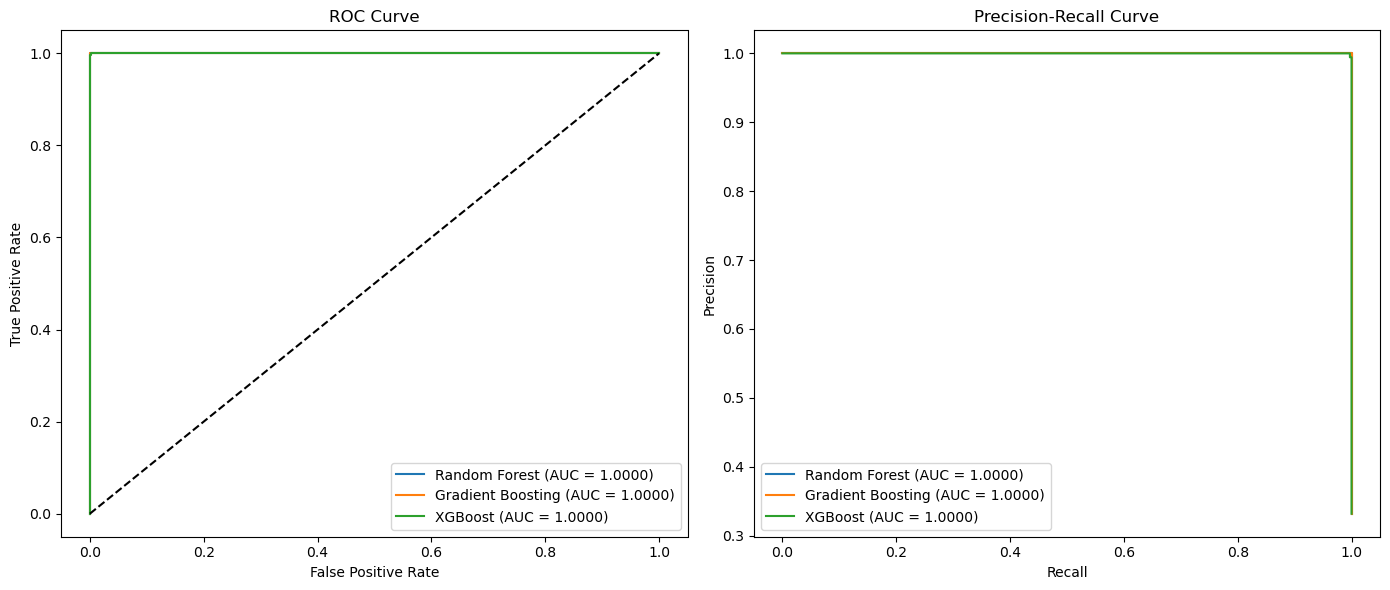


Best model: Random Forest with PR AUC: 1.0000


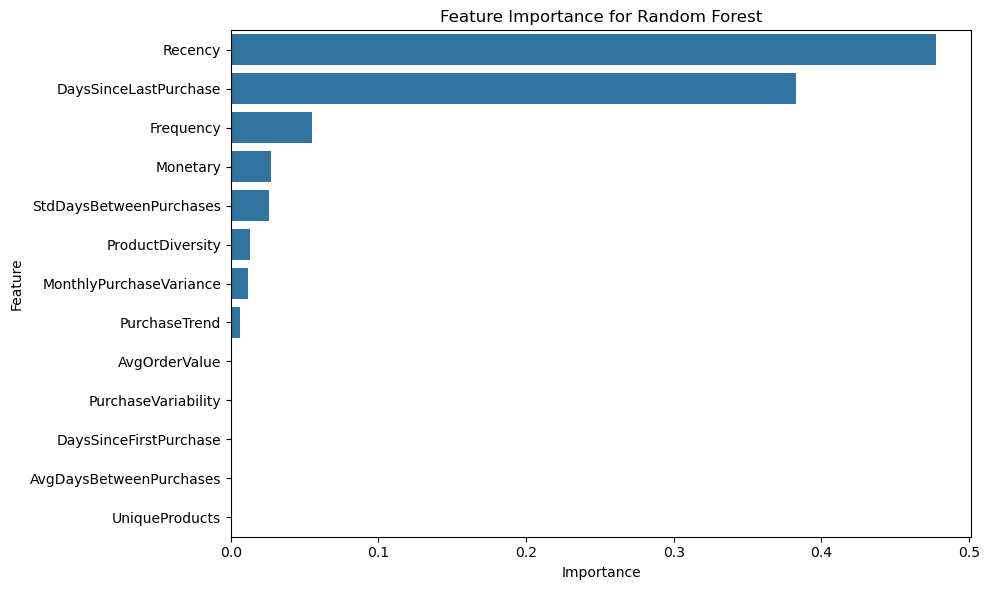


Feature Importance:
                    Feature  Importance
0                   Recency    0.477752
12    DaysSinceLastPurchase    0.382608
1                 Frequency    0.054988
2                  Monetary    0.027415
7   StdDaysBetweenPurchases    0.025714
10         ProductDiversity    0.012999
9   MonthlyPurchaseVariance    0.011972
8             PurchaseTrend    0.006551
3             AvgOrderValue    0.000000
4       PurchaseVariability    0.000000
5    DaysSinceFirstPurchase    0.000000
6   AvgDaysBetweenPurchases    0.000000
11           UniqueProducts    0.000000

Fine-tuning the Random Forest model...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation ROC AUC: 1.0000

Tuned Model Performance:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       701
        True       1.00      1.00      1.00       348

    accuracy                           1.00     

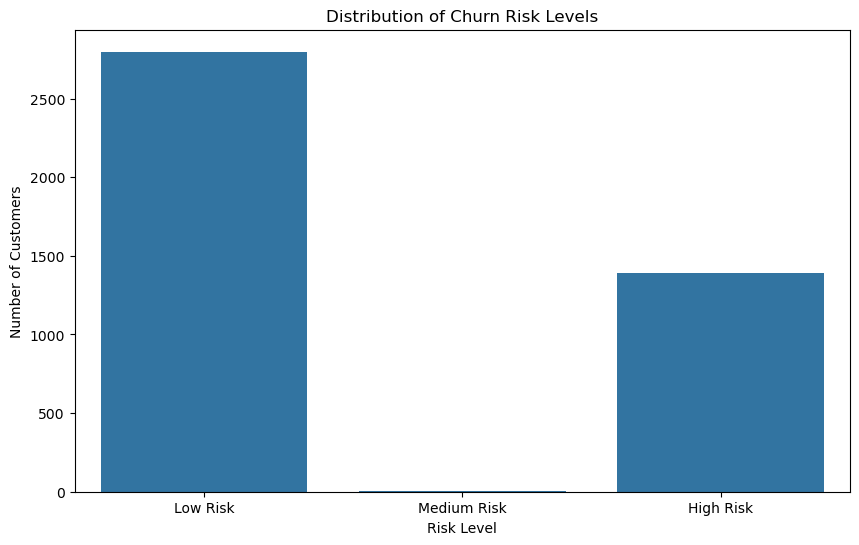


Creating targeted retention strategies...

Retention Strategies by Risk Level:
     RiskLevel                                           Strategy  \
0     Low Risk  Regular engagement, loyalty rewards, cross-sel...   
1  Medium Risk  Special promotions, personalized recommendatio...   
2    High Risk  Urgent win-back campaign, deep discounts, pers...   

   ExpectedRetentionLift  
0                   0.05  
1                   0.15  
2                   0.25  

Expected overall retention improvement: 11.65%

Saving prediction results...

Prediction model and analysis completed!

Analyzing churn risk by customer segment...

Churn Risk Distribution by Segment (%):
RiskLevel           High Risk   Low Risk  Medium Risk
Segment                                              
At Risk            100.000000   0.000000     0.000000
High Value Active    0.549451  99.450549     0.000000
New Customers       12.807718  87.059215     0.133067


<Figure size 1200x800 with 0 Axes>

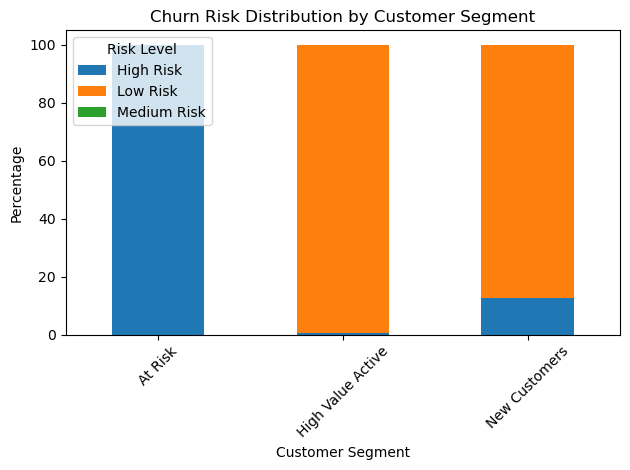


Most at-risk segment: At Risk with 100.0% high-risk customers

Creating prioritized customer list for retention outreach...

Top 10 Customers to Prioritize for Retention:
      CustomerID            Segment  RiskLevel  ChurnProbability  \
3892       17850  High Value Active  High Risk          0.990000   
26         12378      New Customers  High Risk          0.995000   
2153       15379      New Customers  High Risk          0.985000   
1084       13869      New Customers  High Risk          0.990000   
3340       17050      New Customers  High Risk          0.960000   
1145       13952            At Risk  High Risk          1.000000   
275        12688      New Customers  High Risk          0.995000   
2461       15808            At Risk  High Risk          0.980000   
1190       14016      New Customers  High Risk          0.986111   
382        12840      New Customers  High Risk          0.986111   

      CustomerLifetimeValue  PriorityScore  
3892               4732.460    468

In [11]:
# Customer Retention Project - Purchase Prediction
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import pickle
import time

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not installed. Installing now...")
    import sys
    !{sys.executable} -m pip install xgboost
    from xgboost import XGBClassifier

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("imbalanced-learn not installed. Installing now...")
    import sys
    !{sys.executable} -m pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Create directories if they don't exist
os.makedirs('../3_Models', exist_ok=True)
os.makedirs('../1_Data/outputs', exist_ok=True)

# 1. Load the data
print("Loading data...")
try:
    customer_profile = pd.read_csv('../1_Data/processed/customer_segments.csv')
    cleaned_data = pd.read_csv('../1_Data/processed/cleaned_data.csv')
    print("\nCustomer profile shape:", customer_profile.shape)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please make sure you've run the data_cleaning.ipynb and segmentation.ipynb notebooks first.")
    raise

# Print customer_profile columns to debug
print("\nCustomer profile columns:")
print(customer_profile.columns.tolist())

# 2. Prepare the dataset for churn prediction
# We'll define "churn" as not making a purchase within the last 90 days
print("\nPreparing dataset for churn prediction...")

# Convert InvoiceDate to datetime
cleaned_data['InvoiceDate'] = pd.to_datetime(cleaned_data['InvoiceDate'])

# Get the most recent date in the dataset
max_date = cleaned_data['InvoiceDate'].max()
print(f"Most recent transaction date: {max_date}")

# Define churn period (90 days)
churn_threshold = 90

# Calculate the last purchase date for each customer
last_purchase_dates = cleaned_data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase_dates.columns = ['CustomerID', 'LastPurchaseDate']

# Add LastPurchaseDate to customer_profile
customer_profile = pd.merge(customer_profile, last_purchase_dates, on='CustomerID', how='left')

# Calculate days since last purchase
customer_profile['DaysSinceLastPurchase'] = (max_date - customer_profile['LastPurchaseDate']).dt.days

# Create target variable: customers who haven't purchased in the last 90 days are considered churned
customer_profile['Churned'] = customer_profile['DaysSinceLastPurchase'] > churn_threshold

# Display churn rate
churn_rate = customer_profile['Churned'].mean()
print(f"Churn rate: {churn_rate:.2%}")

# 3. Feature engineering for churn prediction
print("\nFeature engineering for churn prediction...")

# 3.1. Create time-based features for more accurate predictions
# Calculate average time between purchases
customer_transactions = cleaned_data.groupby(['CustomerID', 'InvoiceNo']).agg({
    'InvoiceDate': 'min'  # One date per transaction
}).reset_index()

# Sort by customer and date
customer_transactions = customer_transactions.sort_values(['CustomerID', 'InvoiceDate'])

# Calculate days between consecutive purchases for each customer
customer_transactions['PrevInvoiceDate'] = customer_transactions.groupby('CustomerID')['InvoiceDate'].shift(1)
customer_transactions['DaysBetweenPurchases'] = (customer_transactions['InvoiceDate'] - 
                                                customer_transactions['PrevInvoiceDate']).dt.days

# Calculate average and standard deviation of days between purchases
days_between_stats = customer_transactions.groupby('CustomerID').agg({
    'DaysBetweenPurchases': ['mean', 'std']
}).reset_index()

# Fix column names after aggregation
days_between_stats.columns = ['CustomerID', 'AvgDaysBetweenPurchases', 'StdDaysBetweenPurchases']

# 3.2. Add purchase acceleration/deceleration feature
# Get the first half and second half of the customer's purchase history
first_last_purchase = cleaned_data.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max']
}).reset_index()

first_last_purchase.columns = ['CustomerID', 'FirstPurchaseDate', 'LastPurchaseDate']

# For each customer, find the midpoint of their relationship
first_last_purchase['MidpointDate'] = first_last_purchase['FirstPurchaseDate'] + (
    (first_last_purchase['LastPurchaseDate'] - first_last_purchase['FirstPurchaseDate']) / 2
)

# Define function to count purchases in first half and second half of relationship
def count_purchases_by_period(customer_id, midpoint_date):
    customer_invoices = cleaned_data[cleaned_data['CustomerID'] == customer_id]
    first_half = customer_invoices[customer_invoices['InvoiceDate'] <= midpoint_date]['InvoiceNo'].nunique()
    second_half = customer_invoices[customer_invoices['InvoiceDate'] > midpoint_date]['InvoiceNo'].nunique()
    return first_half, second_half

# Create a temporary dataframe for calculations
purchase_trends = pd.DataFrame()
purchase_trends['CustomerID'] = first_last_purchase['CustomerID']
purchase_trends['MidpointDate'] = first_last_purchase['MidpointDate']

# Apply the function to each row (this may take some time)
print("Calculating purchase trends...")
purchase_counts = []
for idx, row in purchase_trends.iterrows():
    first_half, second_half = count_purchases_by_period(row['CustomerID'], row['MidpointDate'])
    purchase_counts.append((first_half, second_half))
    # Print progress every 100 rows
    if idx % 100 == 0:
        print(f"Processed {idx} customers...")

purchase_trends['FirstHalfPurchases'] = [x[0] for x in purchase_counts]
purchase_trends['SecondHalfPurchases'] = [x[1] for x in purchase_counts]

# Calculate purchase trend (positive indicates acceleration, negative indicates deceleration)
purchase_trends['PurchaseTrend'] = (purchase_trends['SecondHalfPurchases'] - 
                                   purchase_trends['FirstHalfPurchases'])

print("Purchase trends calculated.")

# 3.3. Calculate purchase seasonality
# Add month to the transactions
cleaned_data['Month'] = cleaned_data['InvoiceDate'].dt.month

# Calculate total purchases by month for each customer
customer_monthly = cleaned_data.groupby(['CustomerID', 'Month']).agg({
    'InvoiceNo': 'nunique'
}).reset_index()

customer_monthly.columns = ['CustomerID', 'Month', 'PurchaseCount']

# Calculate variance of monthly purchases (higher variance indicates more seasonality)
monthly_variance = customer_monthly.groupby('CustomerID')['PurchaseCount'].var().reset_index()
monthly_variance.columns = ['CustomerID', 'MonthlyPurchaseVariance']

# 3.4. Create product diversity features
# Count distinct product categories purchased
product_diversity = cleaned_data.groupby('CustomerID')['StockCode'].nunique().reset_index()
product_diversity.columns = ['CustomerID', 'ProductDiversity']

# 3.5. Merge all engineered features to the customer profile
# Merge days between purchases stats
customer_profile = pd.merge(customer_profile, days_between_stats, on='CustomerID', how='left')

# Merge purchase trends
customer_profile = pd.merge(customer_profile, purchase_trends[['CustomerID', 'PurchaseTrend']], 
                           on='CustomerID', how='left')

# Merge monthly variance (seasonality)
customer_profile = pd.merge(customer_profile, monthly_variance, on='CustomerID', how='left')

# Merge product diversity
customer_profile = pd.merge(customer_profile, product_diversity, on='CustomerID', how='left')

# Print columns again after all merges
print("\nCustomer profile columns after feature engineering:")
print(customer_profile.columns.tolist())

# Check for NaN values in key columns
print("\nNaN counts in engineered features:")
for col in ['AvgDaysBetweenPurchases', 'StdDaysBetweenPurchases', 'PurchaseTrend', 'MonthlyPurchaseVariance', 'ProductDiversity']:
    if col in customer_profile.columns:
        print(f"{col}: {customer_profile[col].isna().sum()}")
    else:
        print(f"{col}: Column not found")

# 3.6. Fill missing values
# Create columns if they don't exist
required_columns = ['AvgDaysBetweenPurchases', 'StdDaysBetweenPurchases', 'PurchaseTrend', 'MonthlyPurchaseVariance', 'ProductDiversity']
for col in required_columns:
    if col not in customer_profile.columns:
        print(f"Creating missing column: {col}")
        customer_profile[col] = 0

# Fill NaN values with defaults
customer_profile.fillna({
    'AvgDaysBetweenPurchases': 0,
    'StdDaysBetweenPurchases': 0,
    'PurchaseTrend': 0,
    'MonthlyPurchaseVariance': 0,
    'ProductDiversity': 1
}, inplace=True)

# 4. Prepare features and target for model training
print("\nPreparing features and target for model training...")

# Select features for the model
features = [
    'Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 
    'PurchaseVariability', 'DaysSinceFirstPurchase', 'AvgDaysBetweenPurchases',
    'StdDaysBetweenPurchases', 'PurchaseTrend', 'MonthlyPurchaseVariance',
    'ProductDiversity', 'UniqueProducts', 'DaysSinceLastPurchase'
]

# Verify all features exist
missing_features = [f for f in features if f not in customer_profile.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    for col in missing_features:
        print(f"Creating missing feature: {col}")
        customer_profile[col] = 0

# Create X (features) and y (target)
X = customer_profile[features]
y = customer_profile['Churned']

# Check for missing values
print("\nMissing values in features:")
print(X.isnull().sum())

# Fill any remaining missing values
X.fillna(X.median(), inplace=True)

# 5. Split the data into training and testing sets
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Churn rate in training set: {y_train.mean():.2%}")
print(f"Churn rate in testing set: {y_test.mean():.2%}")

# 6. Handle class imbalance with SMOTE
print("\nHandling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training set size after SMOTE: {X_train_resampled.shape}")
print(f"Churn rate in resampled training set: {y_train_resampled.mean():.2%}")

# 7. Scale the features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 8. Train and evaluate models
print("\nTraining and evaluating models...")

# 8.1. Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# 8.2. Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_scaled, y_train_resampled)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    # Store results
    results[name] = {
        'model': model,
        'report': report,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'y_prob': y_prob,
        'training_time': time.time() - start_time
    }
    
    print(f"Training complete. Time taken: {results[name]['training_time']:.2f}s")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

# 8.3. Plot ROC and Precision-Recall curves
plt.figure(figsize=(14, 6))

# ROC curve
plt.subplot(1, 2, 1)
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{name} (AUC = {result['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
for name, result in results.items():
    plt.plot(result['recall'], result['precision'], label=f"{name} (AUC = {result['pr_auc']:.4f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 8.4. Feature importance for the best model
# Determine the best model based on PR AUC (more relevant for imbalanced classification)
best_model_name = max(results, key=lambda x: results[x]['pr_auc'])
best_model = results[best_model_name]['model']

print(f"\nBest model: {best_model_name} with PR AUC: {results[best_model_name]['pr_auc']:.4f}")

# Get feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance:")
    print(feature_importance)

# 9. Fine-tune the best model
print(f"\nFine-tuning the {best_model_name} model...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    best_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

# Get the best model
tuned_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = tuned_model.predict(X_test_scaled)
y_prob_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_prob_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)

print("\nTuned Model Performance:")
print(classification_report(y_test, y_pred_tuned))
print(f"ROC AUC: {roc_auc_tuned:.4f}")
print(f"PR AUC: {pr_auc_tuned:.4f}")

# 10. Save the best model
print("\nSaving the best model...")
with open(f'../3_Models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)

# Save the scaler
with open('../3_Models/prediction_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# 11. Make predictions for all customers
print("\nMaking predictions for all customers...")
X_all_scaled = scaler.transform(X)
churn_probs = tuned_model.predict_proba(X_all_scaled)[:, 1]

# Add predictions to customer profile
customer_profile['ChurnProbability'] = churn_probs

# 12. Identify at-risk customers
print("\nIdentifying at-risk customers...")

# Define risk segments based on churn probability
def assign_risk_level(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

customer_profile['RiskLevel'] = customer_profile['ChurnProbability'].apply(assign_risk_level)

# Display distribution of risk levels
risk_counts = customer_profile['RiskLevel'].value_counts()
print("\nRisk Level Distribution:")
print(risk_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='RiskLevel', data=customer_profile, order=['Low Risk', 'Medium Risk', 'High Risk'])
plt.title('Distribution of Churn Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Customers')
plt.show()

# 13. Create targeted retention strategies
print("\nCreating targeted retention strategies...")

# Define strategies for each risk level
retention_strategies = pd.DataFrame({
    'RiskLevel': ['Low Risk', 'Medium Risk', 'High Risk'],
    'Strategy': [
        'Regular engagement, loyalty rewards, cross-sell opportunities',
        'Special promotions, personalized recommendations, incentives for next purchase',
        'Urgent win-back campaign, deep discounts, personalized outreach, exit survey'
    ],
    'ExpectedRetentionLift': [0.05, 0.15, 0.25]
})

print("\nRetention Strategies by Risk Level:")
print(retention_strategies)

# Calculate expected retention improvement
risk_level_counts = customer_profile['RiskLevel'].value_counts(normalize=True)
expected_lift = sum(risk_level_counts[level] * retention_strategies.loc[retention_strategies['RiskLevel'] == level, 'ExpectedRetentionLift'].values[0] 
                   for level in risk_level_counts.index)

print(f"\nExpected overall retention improvement: {expected_lift:.2%}")

# 14. Save the results
print("\nSaving prediction results...")

# Save customer profile with risk levels
customer_profile.to_csv('../1_Data/outputs/customer_risk_predictions.csv', index=False)

# Save retention strategies
retention_strategies.to_csv('../1_Data/outputs/retention_strategies.csv', index=False)

print("\nPrediction model and analysis completed!")

# 15. Create churn risk breakdown by segment
print("\nAnalyzing churn risk by customer segment...")

# Cross-tabulate segment vs risk level
segment_risk_cross = pd.crosstab(
    customer_profile['Segment'], 
    customer_profile['RiskLevel'],
    normalize='index'
) * 100

print("\nChurn Risk Distribution by Segment (%):")
print(segment_risk_cross)

# Visualize segment vs risk level
plt.figure(figsize=(12, 8))
segment_risk_cross.plot(kind='bar', stacked=True)
plt.title('Churn Risk Distribution by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Risk Level')
plt.tight_layout()
plt.show()

# Calculate the most at-risk segment
most_at_risk_segment = segment_risk_cross['High Risk'].idxmax()
print(f"\nMost at-risk segment: {most_at_risk_segment} with {segment_risk_cross.loc[most_at_risk_segment, 'High Risk']:.1f}% high-risk customers")

# 16. Create a prioritized customer list for retention outreach
print("\nCreating prioritized customer list for retention outreach...")

# Select customers with medium to high risk
at_risk_customers = customer_profile[customer_profile['RiskLevel'] != 'Low Risk'].copy()

# Calculate customer lifetime value (simple version: total monetary value)
at_risk_customers['CustomerLifetimeValue'] = at_risk_customers['Monetary']

# Calculate priority score (higher score = higher priority for retention)
# We'll prioritize high-value customers who are at risk
at_risk_customers['PriorityScore'] = at_risk_customers['CustomerLifetimeValue'] * at_risk_customers['ChurnProbability']

# Sort by priority score
prioritized_customers = at_risk_customers.sort_values('PriorityScore', ascending=False)

# Display top 10 customers to prioritize
print("\nTop 10 Customers to Prioritize for Retention:")
print(prioritized_customers[['CustomerID', 'Segment', 'RiskLevel', 'ChurnProbability', 'CustomerLifetimeValue', 'PriorityScore']].head(10))

# Save prioritized customer list
prioritized_customers[['CustomerID', 'Segment', 'RiskLevel', 'ChurnProbability', 'CustomerLifetimeValue', 'PriorityScore']].to_csv(
    '../1_Data/outputs/prioritized_retention_list.csv', index=False
)

print("\nPrioritized customer list saved to '../1_Data/outputs/prioritized_retention_list.csv'")

In [7]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   --